# Init

In [1]:
import pandas as pd
import numpy as np
from nltk.tokenize import word_tokenize
import datetime
import html2text
import re
from nltk.corpus import stopwords

In [2]:
import seaborn as sns
import matplotlib.pyplot as plt
from wordcloud import WordCloud
%matplotlib inline

In [3]:
from plotly import __version__
from plotly.offline import download_plotlyjs, init_notebook_mode, plot, iplot
from plotly.offline.offline import _plot_html
import cufflinks as cf

init_notebook_mode(connected=True)
cf.go_offline()

IOPub data rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_data_rate_limit`.


In [4]:
from sklearn import metrics
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import CountVectorizer

In [6]:
def clean_txt(text):
    search = ['أ','آ','إ','ة','ى']
    replace = ['ا','ا','ا','ه','ي']
    
    
    for i in range(len(search)):
        text = text.replace(search[i], replace[i])
    
    words = re.split("[^0-9a-zA-Zابتثجحخدزرزسشصضطظعغفقكلومنهةىؤئء,يأآئ]*", text)
    
    return " ".join(words).strip().lower()


def filter_exp_years(text):
    #check if there are numbers
    text = text.replace("-", ' - ')
    text = text.replace("+", ' - ')
    text = text.replace("/", ' - ')
    text = text.replace("~", ' - ')
    text = word_tokenize(text)
    
    numbers = [int(s) for s in text if s.isdigit()]
    words = [s.lower().strip() for s in text if not s.isdigit()]
    
    per = 'year'
    if('month' in words or 'months' in words):
        per = 'month'
    if(len(numbers) == 1):
        if('less' in words or 'maximum' in words): 
            return (0,max(numbers), per)
        elif('more' in words or 'above' in words or 'minimum' in words):
            return (max(numbers),max(numbers), per)
        else:
            return (0,max(numbers), per)
    elif (len(numbers) > 1):
        return (min(numbers), max(numbers), per)
    else:
        return (0,0, per)

# Load Data

In [5]:
df = pd.read_csv('data_science_dataset_wuzzuf.csv')

### Define/Edit New Data Clone

In [18]:
# copy df and append new cols
df_2 = df.copy()
df_2['salary_avg'] = pd.Series(0, index=df.index)
df_2['clean_description'] = pd.Series('', index=df.index)
df_2['clean_job_requirements'] = pd.Series('', index=df.index)
df_2['date_year'] = pd.Series('', index=df.index)
df_2['date_month'] = pd.Series('', index=df.index)
df_2['experience_years_type'] = pd.Series('year', index=df.index)
df_2['experience_years_min'] = pd.Series(0, index=df.index)
df_2['experience_years_max'] = pd.Series(0, index=df.index)

### Data Cleaning

In [19]:
err = 0
for i in range(df_2.shape[0]):
    # filter salary
    if(int(df_2.iloc[i]['salary_min']) <= 0 ):
        df_2.set_value(i, 'salary_min', 0)
    if(int(df_2.iloc[i]['salary_max']) <= 0 ):
        df_2.set_value(i, 'salary_max', 0)

    df_2.set_value(i, 'salary_avg', (df_2.iloc[i]['salary_max'] + df_2.iloc[i]['salary_min'])/2.0 )
    
    # filter num vacancies
    if(int(df_2.iloc[i]['num_vacancies']) <= 0 ):
        df_2.set_value(i, 'num_vacancies', 0)
    
    # filter exp years
    exp_yrs = filter_exp_years(str(df_2.iloc[i]['experience_years']))
    df_2.set_value(i, 'experience_years_min', exp_yrs[0])
    df_2.set_value(i, 'experience_years_max', exp_yrs[1])
    df_2.set_value(i, 'experience_years_type', exp_yrs[2])
    
    # parse date/time
    d = df_2.iloc[i]['post_date'].split('-')
    df_2.set_value(i, 'date_year', d[0])
    df_2.set_value(i, 'date_month', datetime.date(1900, int(d[1]), 1).strftime('%B'))
    
    # filter job_reqs
    df_2.set_value(i, 'clean_description', html2text.html2text(str(df_2.iloc[i]['description'])))
    df_2.set_value(i, 'clean_job_requirements', html2text.html2text(str(df_2.iloc[i]['job_requirements'])))
    
    # filter city_name
    df_2.set_value(i, 'city_name', clean_txt(df_2.iloc[i]['city_name']))
    

/usr/lib/python3.5/re.py:203: FutureWarning:

split() requires a non-empty pattern match.



#### City Names Normalizing | Cleaning

In [20]:
# load cities lexicon
c_lex = []
for line in open('cities.csv'):
    words = clean_txt(line).split(',')
    c_lex.append(words)

/usr/lib/python3.5/re.py:203: FutureWarning:

split() requires a non-empty pattern match.



In [21]:
# clean city names [filter|normalize]
city_jobs_counts = {}
dbl = 0
dbl_queue = []
for i in range(df.shape[0]):
    if i+1%100 == 0: print(i)
    city_words = word_tokenize(df_2.iloc[i]['city_name'].lower())

    for c in c_lex:
        for w in city_words:
            if w in c or  w.replace('ال','') in c:
                df_2.set_value(i, 'city_name', c[0])
                if c[0] in city_jobs_counts:
                    city_jobs_counts[c[0]] += 1
                else:
                    city_jobs_counts[c[0]] = 0

# sort by top countries
df_2['city_name'].value_counts().sort_values(inplace=True, ascending=False)

In [23]:
df_2.iloc[208]

id                                                                 afb02d06
city_name                                                             cairo
displayed_job_title                                      Web Content Writer
job_category_1                                            Editorial/Writing
job_category_2                                                    Marketing
job_category_3                                                     Research
job_industry_1                                          Writing and Editing
job_industry_2                                 Marketing and Advertising   
job_industry_3                                                  Research   
salary_min                                                             2000
salary_max                                                             2500
num_vacancies                                                             1
career_level                                                    Entry Level
experience_y

#### Job Titles Normalizing | Cleaning

In [24]:
# clean displayed_job_title
for i in range(df_2.shape[0]):
    df_2.set_value(i, 'displayed_job_title', clean_txt(df_2.iloc[i]['displayed_job_title']))

/usr/lib/python3.5/re.py:203: FutureWarning:

split() requires a non-empty pattern match.



# Analytics

## Cities

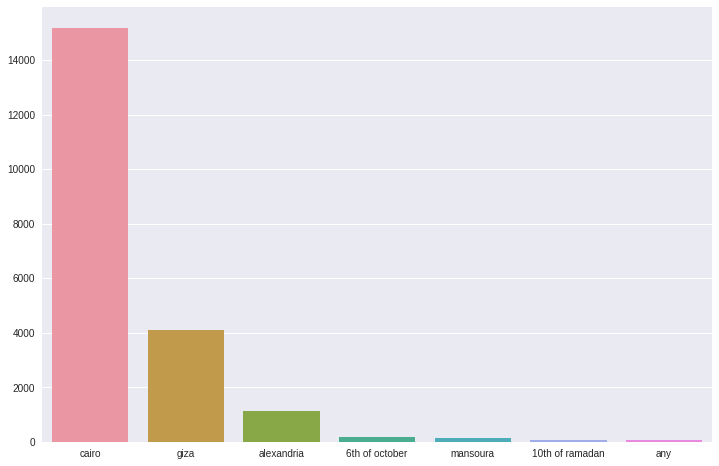

In [25]:
# top cities jobs
dt = [ df_2['city_name'].value_counts().index[z] for z in range(7)]
counts = [ df_2['city_name'].value_counts()[z] for z in range(7)]

plt.figure(figsize=(12,8))
sns.barplot(x=dt,y=counts)

## views

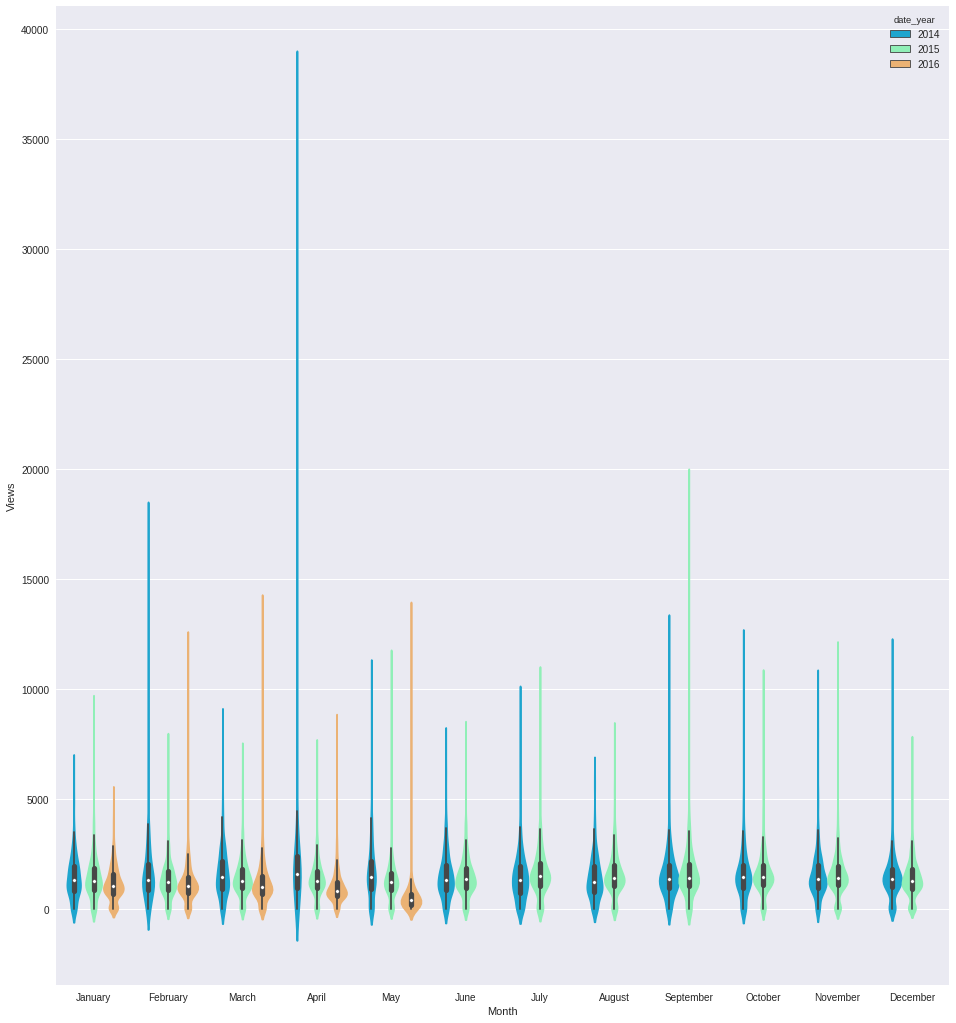

In [29]:
# view per months [violinplot]
plt.figure(figsize=(16,18))
ax = sns.violinplot(x="date_month", y="views",hue='date_year', data=df_2,palette='rainbow',estimator=sum)
ax.set(xlabel='Month', ylabel='Views')
plt.show()

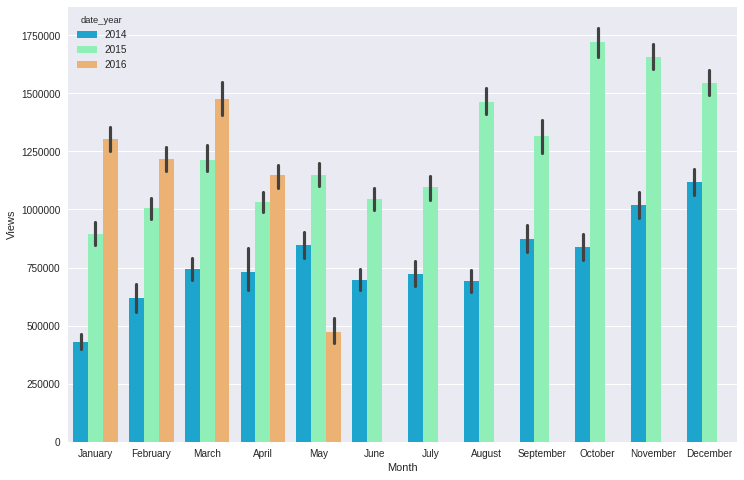

In [30]:
# view per months [bar] - per three years
plt.figure(figsize=(12,8))
ax = sns.barplot(x="date_month", y="views", data=df_2,hue='date_year',palette='rainbow',estimator=sum)
ax.set(xlabel='Month', ylabel='Views')
plt.show()

In [31]:
# sum(views) per month
df_2.pivot_table(values='views',index='date_month',columns='date_year',aggfunc=sum, fill_value=0)

date_year,2014,2015,2016
date_month,,,
April,731758,1031766,1147785
August,693186,1464019,0
December,1117150,1546430,0
February,617031,1005274,1218766
January,429304,892766,1302518
July,722772,1096054,0
June,696230,1044796,0
March,744087,1214453,1476539
May,847516,1146969,474433


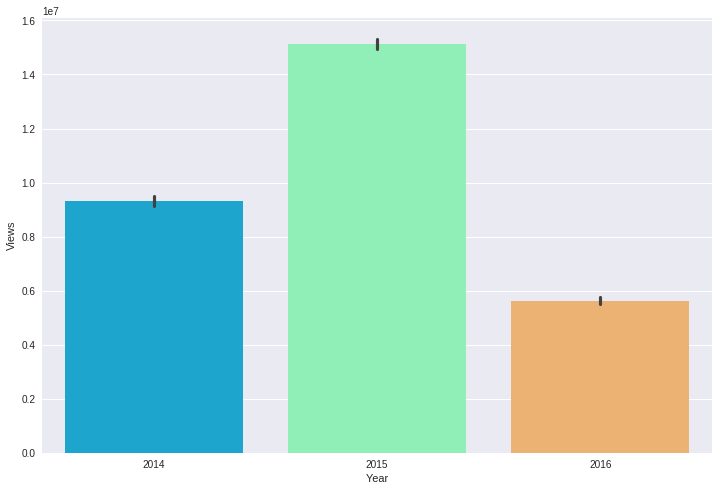

In [33]:
# years / views
plt.figure(figsize=(12,8))
ax = sns.barplot(x="date_year", y="views", data=df_2,palette='rainbow',estimator=sum)
ax.set(xlabel='Year', ylabel='Views')
plt.show()

## Published Jobs

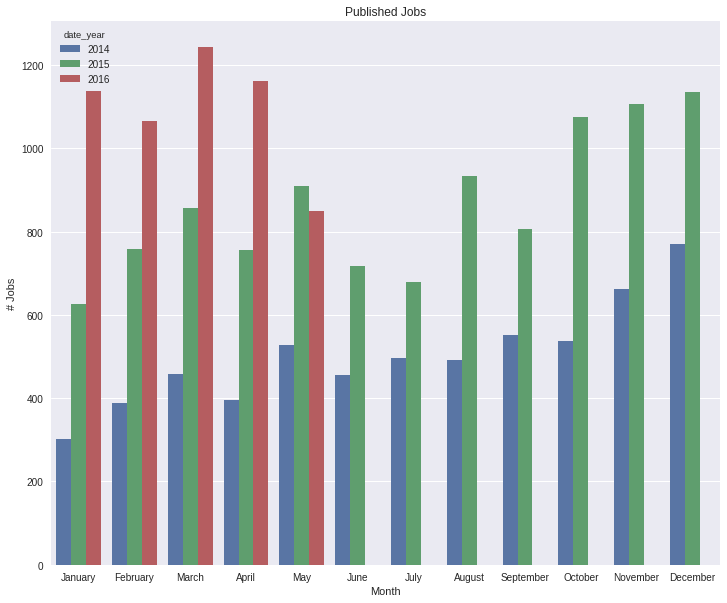

In [40]:
# jobs published per months/year
plt.figure(figsize=(12,10))
ax = sns.countplot(x="date_month", hue='date_year' ,data=df_2)
ax.set(xlabel='Month', ylabel='# Jobs',title="Published Jobs")
plt.show()

In [41]:
df_2.pivot_table(values='views',index='date_month',columns='date_year',aggfunc=len, fill_value=0)

date_year,2014,2015,2016
date_month,,,
April,395,755,1162
August,492,934,0
December,771,1135,0
February,389,759,1065
January,303,625,1137
July,497,679,0
June,455,717,0
March,458,856,1243
May,527,909,849


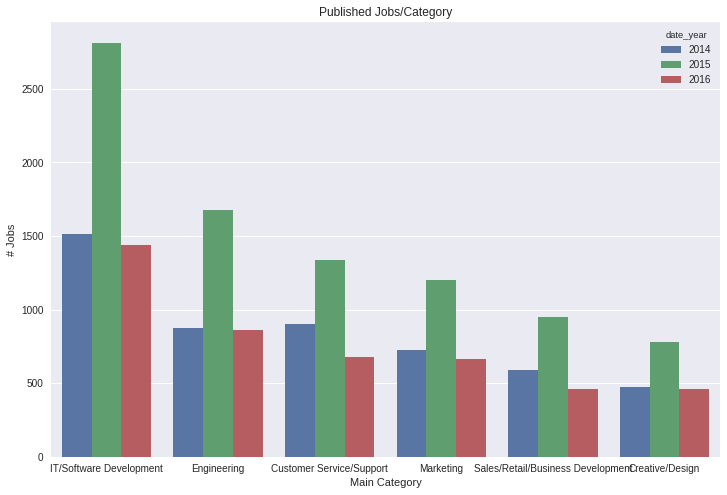

In [43]:
# top 6 categories published jobs
plt.figure(figsize=(12,8))
ax = sns.countplot(x="job_category_1", hue='date_year' ,data=df_2, order=df_2['job_category_1'].value_counts().iloc[:6].index)
ax.set(xlabel='Main Category', ylabel='# Jobs',title="Published Jobs/Category")
plt.show()

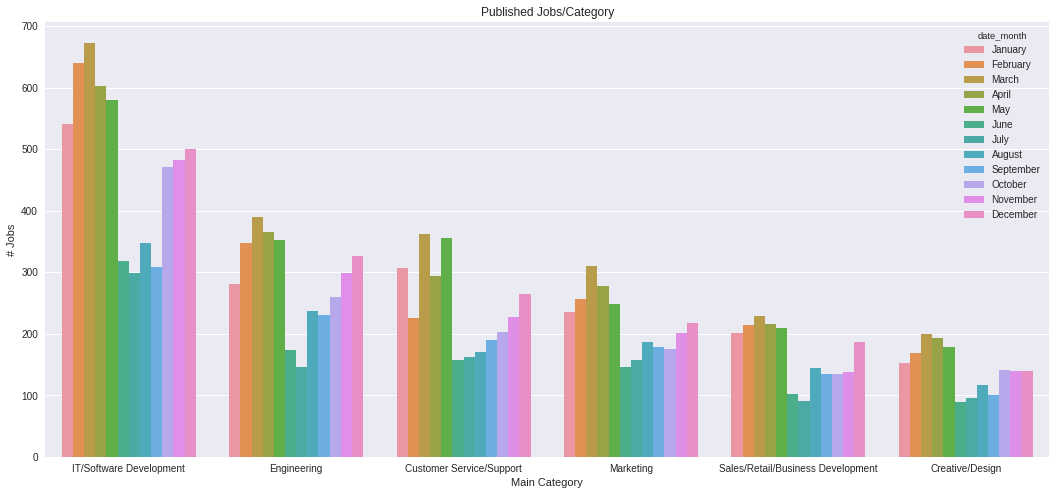

In [44]:
# jobs published category/month
plt.figure(figsize=(18,8))
ax = sns.countplot(x="job_category_1", hue='date_month' ,data=df_2, order=df_2['job_category_1'].value_counts().iloc[:6].index)
ax.set(xlabel='Main Category', ylabel='# Jobs',title="Published Jobs/Category")
plt.show()

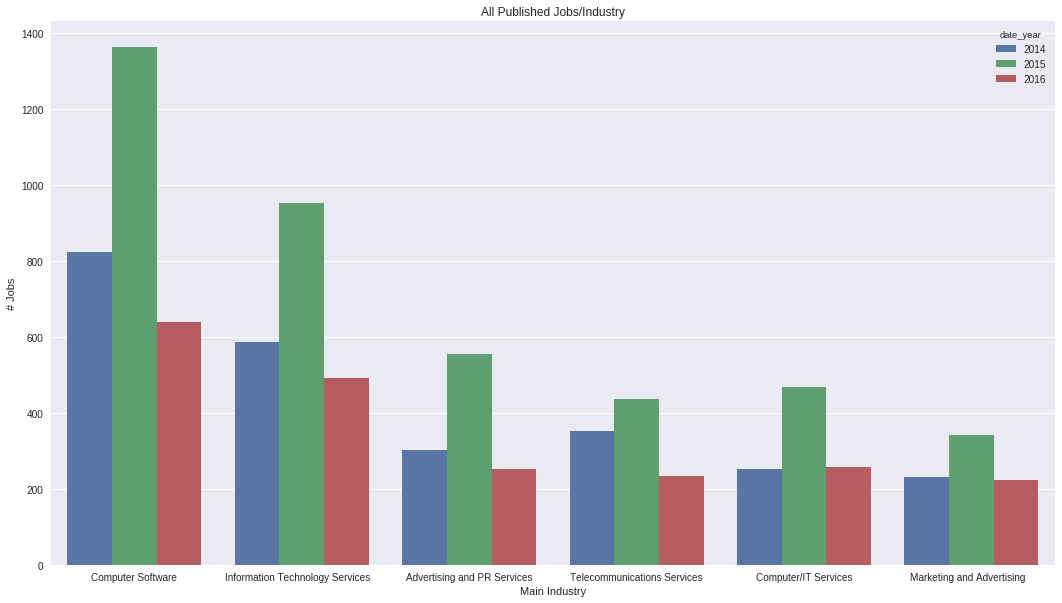

In [47]:
# jobs published industry/year
plt.figure(figsize=(18,10))
ax = sns.countplot(x="job_industry_1", hue='date_year' ,data=df_2, order=df_2['job_industry_1'].value_counts().iloc[:6].index)
ax.set(xlabel='Main Industry', ylabel='# Jobs',title="All Published Jobs/Industry")
plt.show()

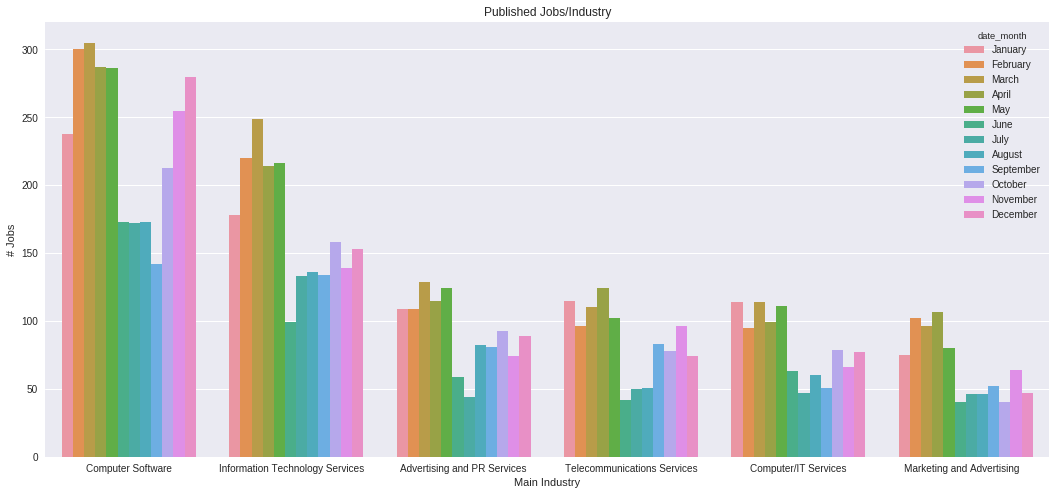

In [48]:
# jobs published industry/year
plt.figure(figsize=(18,8))
ax = sns.countplot(x="job_industry_1", hue='date_month' ,data=df_2, order=df_2['job_industry_1'].value_counts().iloc[:6].index)
ax.set(xlabel='Main Industry', ylabel='# Jobs',title="Published Jobs/Industry")
plt.show()

In [51]:
# number of missed/existed job_category_2
print("Non-Selected: ",sum(df_2[df_2['job_category_2']!='Select']['job_category_2'].value_counts()))
print("Selected: ",df_2[df_2['job_category_2']=='Select']['job_category_2'].value_counts())

# number of missed/existed job_category_3
print("Non-Selected: ",sum(df_2[df_2['job_category_3']!='Select']['job_category_3'].value_counts()))
print("Selected: ",df_2[df_2['job_category_3']=='Select']['job_category_3'].value_counts())

Non-Selected:  11591
Selected:  Select    10259
Name: job_category_2, dtype: int64
Non-Selected:  3062
Selected:  Select    18788
Name: job_category_3, dtype: int64


In [52]:
# number of missed/existed job_category_2
print("Non-Selected: ",sum(df_2[df_2['job_industry_2']!='Select']['job_industry_2'].value_counts()))
print("Selected: ",df_2[df_2['job_industry_2']=='Select']['job_industry_2'].value_counts())

# number of missed/existed job_category_3
print("Non-Selected: ",sum(df_2[df_2['job_industry_3']!='Select']['job_industry_3'].value_counts()))
print("Selected: ",df_2[df_2['job_industry_3']=='Select']['job_industry_3'].value_counts())

Non-Selected:  9149
Selected:  Select    12701
Name: job_industry_2, dtype: int64
Non-Selected:  4074
Selected:  Select    17776
Name: job_industry_3, dtype: int64


## Salaries

In [54]:
# not dedicated salaries
print("Not Dedicated Salaries: ",df_2[(df_2['salary_min'] ==0) & (df_2['salary_min'] ==0)].shape[0])

Not Dedicated Salaries:  189


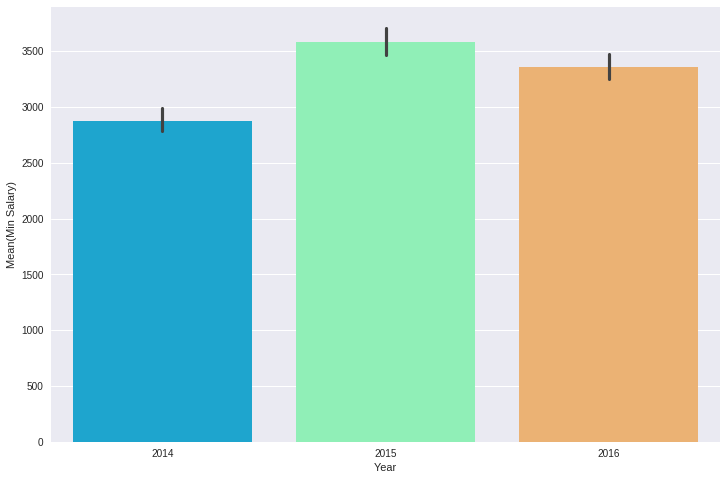

In [56]:
# mean of min salaries / year
plt.figure(figsize=(12,8))
ax = sns.barplot(x="date_year", y="salary_min", data=df_2,palette='rainbow')
ax.set(xlabel='Year', ylabel='Mean(Min Salary)')
plt.show()

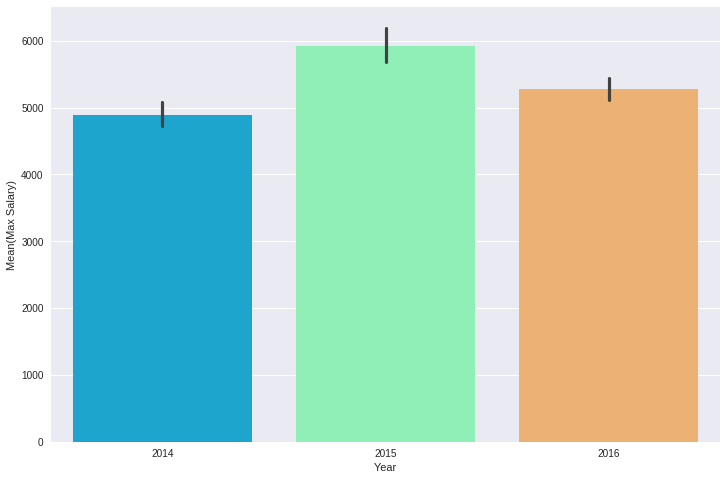

In [57]:
# mean of max salaries / year
plt.figure(figsize=(12,8))
ax = sns.barplot(x="date_year", y="salary_max", data=df_2,palette='rainbow')
ax.set(xlabel='Year', ylabel='Mean(Max Salary)')
plt.show()

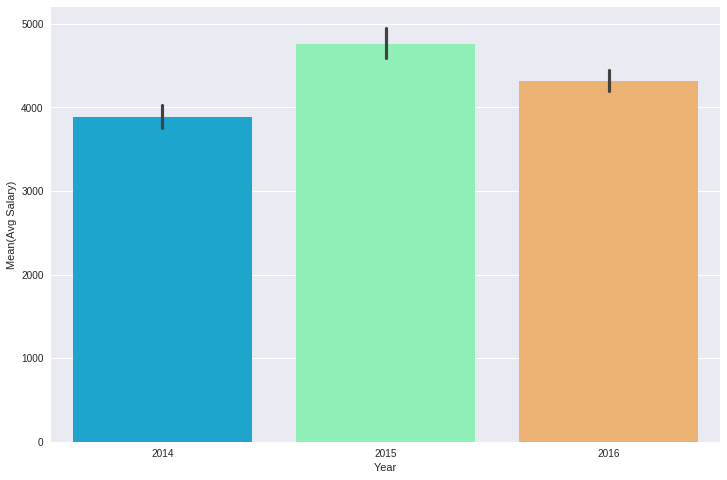

In [58]:
# mean of max salaries / year
plt.figure(figsize=(12,8))
ax = sns.barplot(x="date_year", y="salary_avg", data=df_2,palette='rainbow')
ax.set(xlabel='Year', ylabel='Mean(Avg Salary)')
plt.show()

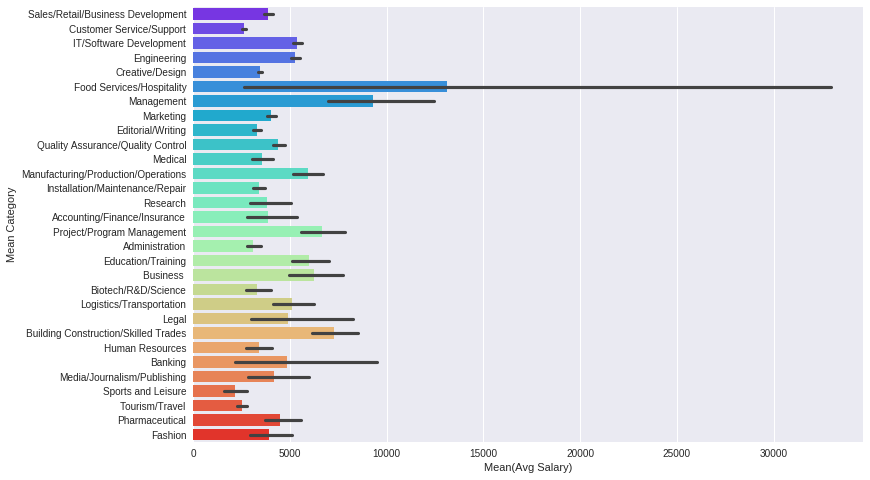

In [60]:
# mean of avg salaries / job_category_1 - all
plt.figure(figsize=(12,8))
ax = sns.barplot(x="salary_avg", y="job_category_1", data=df_2,palette='rainbow')
ax.set(xlabel='Mean(Avg Salary)', ylabel='Mean Category')
plt.show()

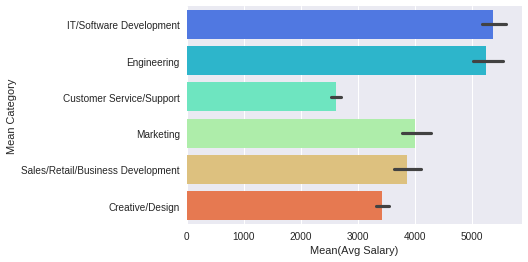

In [61]:
# avg salaries per top 6 published categories jobs
ax = sns.barplot(x="salary_avg", y="job_category_1", data=df_2,palette='rainbow',order=df_2['job_category_1'].value_counts().iloc[:6].index)
ax.set(xlabel='Mean(Avg Salary)', ylabel='Mean Category')
plt.show()

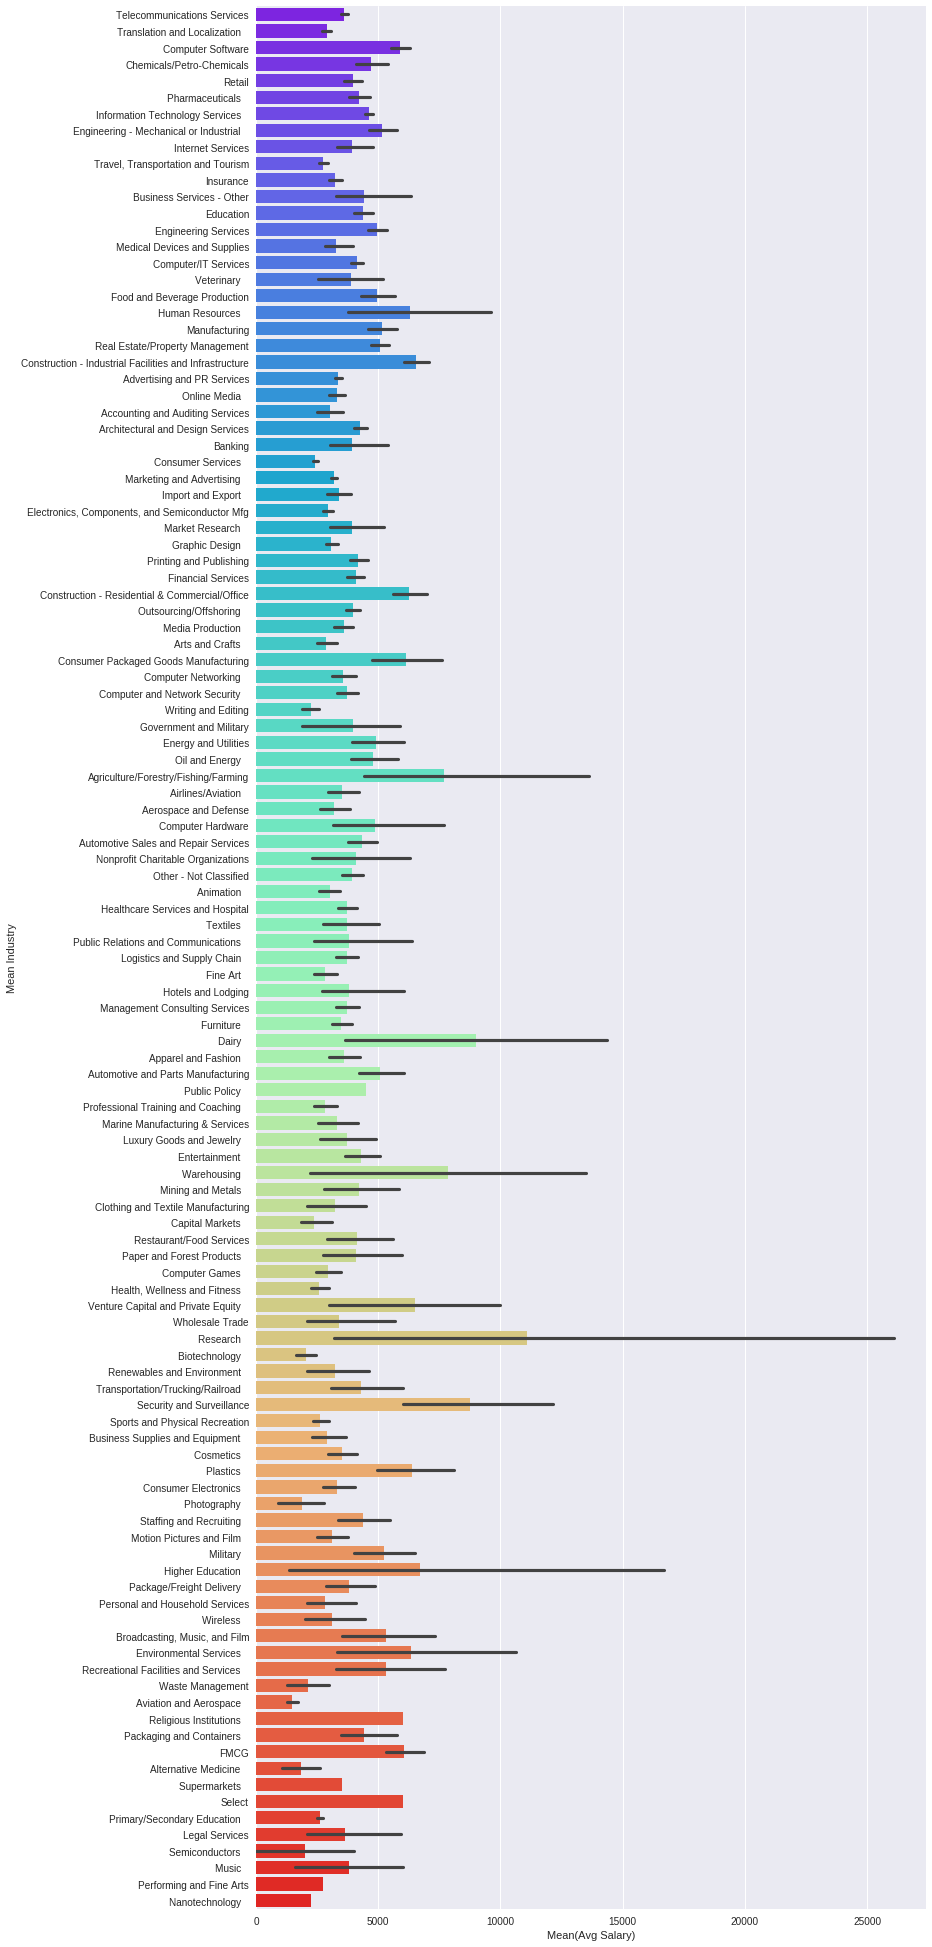

In [63]:
# mean of avg salaries / job_industry_1 - all
plt.figure(figsize=(12,35))
ax = sns.barplot(x="salary_avg", y="job_industry_1", data=df_2,palette='rainbow')
ax.set(xlabel='Mean(Avg Salary)', ylabel='Mean Industry')
plt.show()

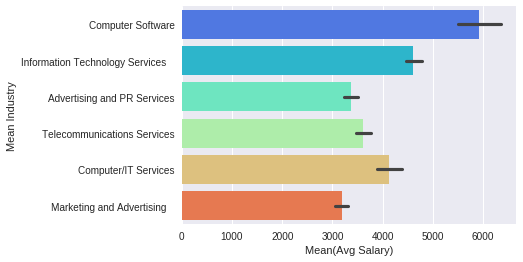

In [64]:
ax = sns.barplot(x="salary_avg", y="job_industry_1", data=df_2,palette='rainbow',order=df_2['job_industry_1'].value_counts().iloc[:6].index)
ax.set(xlabel='Mean(Avg Salary)', ylabel='Mean Industry')
plt.show()

In [65]:
# Overall Mean Projects
df_2.pivot_table(index='date_month',columns='date_year',aggfunc='mean')

experience_years_max                     experience_years_min  \
date_year                  2014      2015      2016                 2014   
date_month                                                                 
April                  3.217722  3.863576  3.567986             0.832911   
August                 3.398374  3.643469       NaN             0.973577   
December               3.769131  3.566520       NaN             1.068742   
February               3.673522  3.802372  3.745540             1.074550   
January                3.462046  3.547200  3.463500             0.970297   
July                   3.364185  3.480118       NaN             0.782696   
June                   3.347253  3.543933       NaN             0.949451   
March                  3.831878  3.538551  3.525342             1.102620   
May                    3.294118  3.572057  3.699647             0.998102   
November               3.754917  3.479204       NaN             1.173979   
October                3.348231  3.944186       NaN             0.813780   
September              3.403986  3.762082       NaN             0.898551   

                               num_vacancies                       salary_avg  \
date_year       2015      2016          2014      2015      2016         2014   
date_month                                                                      
April       1.075497  1.081756      8.987342  4.719205  6.048193  3208.420253   
August      1.118844       NaN      6.955285  5.033191       NaN  4031.646341   
December    0.935683       NaN      5.181582  6.769163       NaN  4314.578470   
February    1.077734  1.054460      6.375321  4.038208  4.230047  4117.030848   
January     0.857600  0.959543      6.937294  6.441600  6.032542  3794.821782   
July        1.078056       NaN      5.955734  4.001473       NaN  3907.257545   
June        1.012552       NaN      6.896703  5.938633       NaN  3895.206593   
March       0.934579  1.068383      6.703057  6.389019  5.849558  3955.329694   
May         0.991199  1.180212      9.056926  7.006601  4.559482  3489.791271   
November    0.893309       NaN      6.237519  6.216094       NaN  3872.636914   
October     1.052093       NaN      6.560521  4.496744       NaN  3908.951583   
September   1.006196       NaN      5.536232  5.809170       NaN  3773.369565   

               ...                     salary_max                            \
date_year      ...              2016         2014         2015         2016   
date_month     ...                                                            
April          ...       3977.730637  3946.711392  5838.357616  4876.561962   
August         ...               NaN  5103.821138  5343.888651          NaN   
December       ...               NaN  5356.390402  6496.236123          NaN   
February       ...       4429.411268  5103.084833  5280.096179  5447.897653   
January        ...       4668.882146  4730.026403  5239.459200  5589.662269   
July           ...               NaN  5326.026157  5295.702504          NaN   
June           ...               NaN  4841.760440  5120.926081          NaN   
March          ...       4264.663717  4956.672489  7491.241822  5231.854385   
May            ...       4237.050648  4265.284630  5280.187019  5221.664311   
November       ...               NaN  4785.467474  6251.448463          NaN   
October        ...               NaN  4970.707635  7169.018605          NaN   
September      ...               NaN  4869.021739  5241.257745          NaN   

             salary_min                                  views               \
date_year          2014         2015         2016         2014         2015   
date_month                                                                    
April       2470.129114  3511.063576  3078.901893  1852.551899  1366.577483   
August      2959.471545  3170.862955          NaN  1408.914634  1567.472163   
December    3272.770428  4197.595595          NaN  1448.962387  1362.4933

## Vacancies

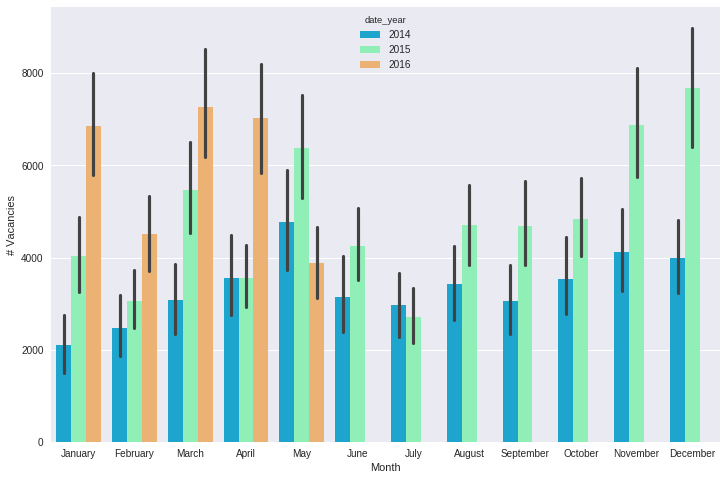

In [67]:
# vacancies [months/years]
plt.figure(figsize=(12,8))
ax = sns.barplot(x="date_month", y="num_vacancies", data=df_2,hue='date_year',palette='rainbow',estimator=sum)
ax.set(xlabel='Month', ylabel='# Vacancies')
plt.show()

## Career Levels

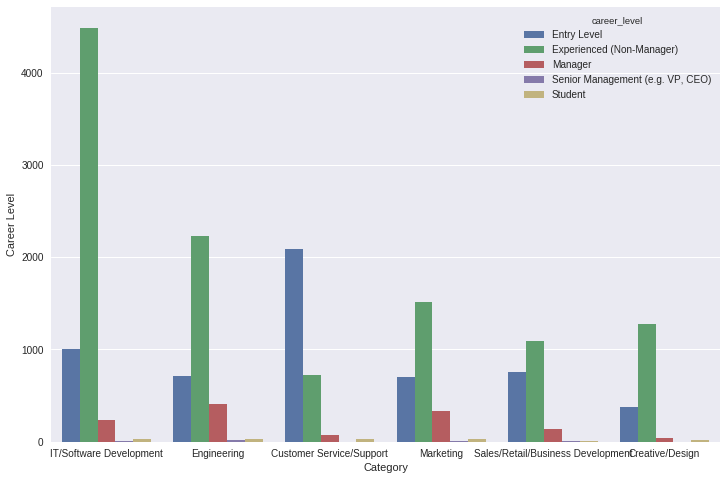

In [71]:
# no. career levels jobs / top job_categories
plt.figure(figsize=(12,8))
ax = sns.countplot(x="job_category_1", hue='career_level' ,data=df_2, order=df_2['job_category_1'].value_counts().iloc[:6].index)
ax.set(xlabel='Category', ylabel='Career Level')
plt.show()

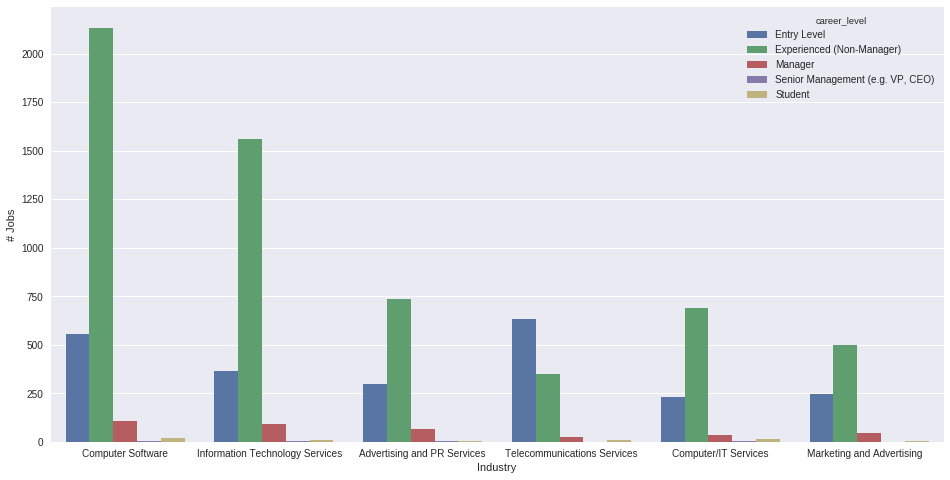

In [70]:
# career levels count / top job_industries
plt.figure(figsize=(16,8))
ax = sns.countplot(x="job_industry_1", hue='career_level' ,data=df_2, order=df_2['job_industry_1'].value_counts().iloc[:6].index)
ax.set(xlabel='Industry', ylabel='# Jobs')
plt.show()

## job Titles

In [72]:
# remove english stop words
all_text = " ".join(df_2['displayed_job_title'])
clean_text = [word for word in all_text.split() if word not in stopwords.words('english')]
clean_text = " ".join(clean_text)

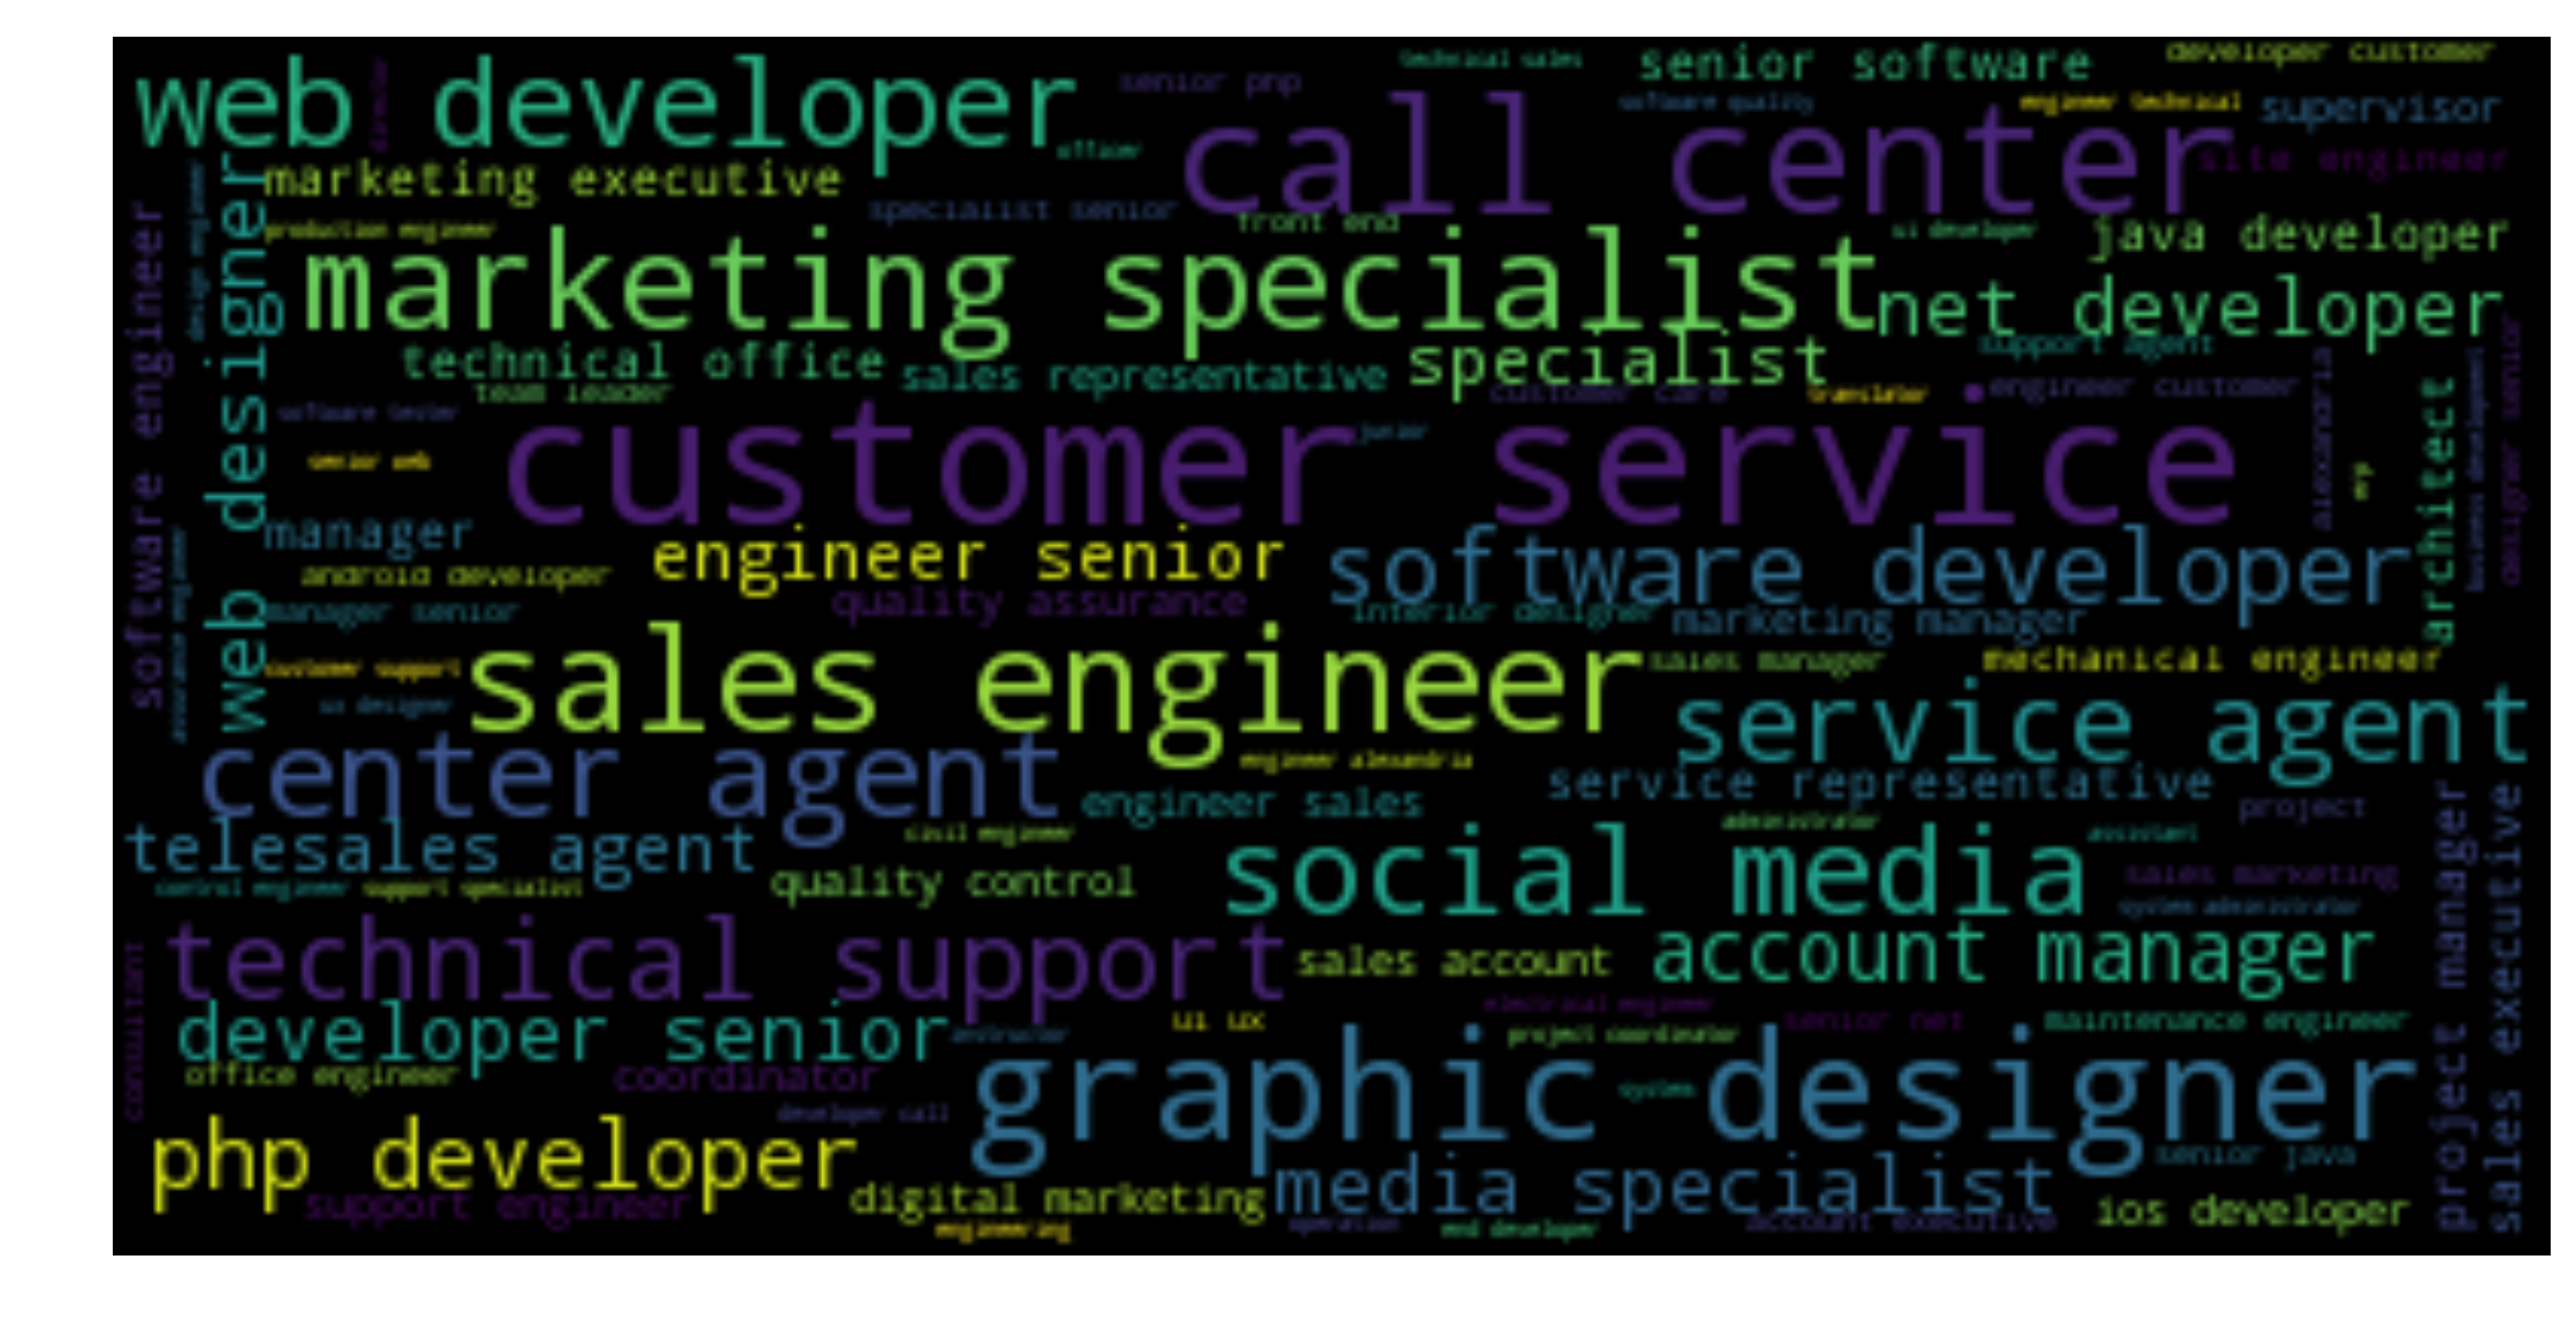

In [73]:
# WordCloud of Job Titles
wordcloud = WordCloud(max_font_size=30).generate(clean_text)
plt.figure(figsize=(12, 16), dpi=300, facecolor='w', edgecolor='k')
plt.imshow(wordcloud, interpolation="bilinear")
plt.axis("off")
plt.show()

In [75]:
# top 50 job titles [2,3]-grams
from sklearn.feature_extraction.text import CountVectorizer
word_vectorizer = CountVectorizer(ngram_range=(2,4), analyzer='word')
sparse_matrix = word_vectorizer.fit_transform(df_2['displayed_job_title'])
frequencies = sum(sparse_matrix).toarray()[0]

In [76]:
job_title_keywords = pd.DataFrame(frequencies, index=word_vectorizer.get_feature_names(), columns=['frequency'])
job_title_keywords.sort_values(['frequency'], ascending=[False], inplace=True)
job_title_keywords.head(50)

,frequency
customer service,1000
call center,772
graphic designer,755
sales engineer,653
marketing specialist,613
social media,503
web developer,490
center agent,480
call center agent,478
technical support,421


# Machine Learnign - Data Mining

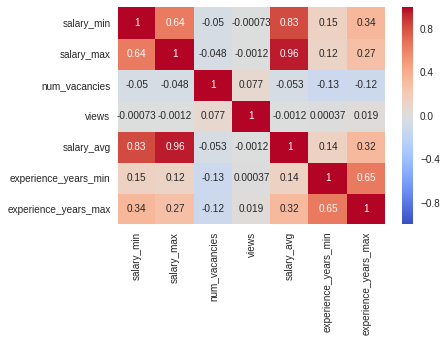

In [77]:
sns.heatmap(df_2.corr(),cmap='coolwarm',annot=True)

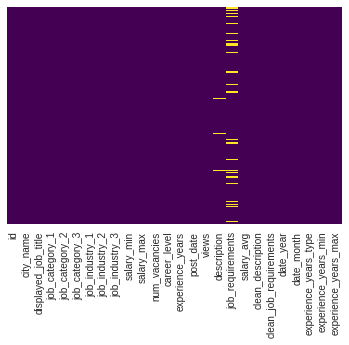

In [78]:
# null heatmap
sns.heatmap(df_2.isnull(),yticklabels=False,cbar=False,cmap='viridis')

## Data Pre-Processing

In [79]:
# change categories to numbers
df_2['job_industry_1'] = pd.Categorical(df_2['job_industry_1'])
df_2['job_industry_1_codes'] = df_2['job_industry_1'].cat.codes

df_2['job_category_1'] = pd.Categorical(df_2['job_category_1'])
df_2['job_category_1_codes'] = df_2['job_category_1'].cat.codes

df_2['career_level'] = pd.Categorical(df_2['career_level'])
df_2['career_level_codes'] = df_2['career_level'].cat.codes

df_2['city_name'] = pd.Categorical(df_2['city_name'])
df_2['city_name_codes'] = df_2['city_name'].cat.codes

df_2['date_month'] = pd.Categorical(df_2['date_month'])
df_2['date_month_codes'] = df_2['date_month'].cat.codes

## Views Linear Regression

In [119]:
# Linear regression to predict views
train_data = df_2[df_2['views']>0][['experience_years_min', 'experience_years_max','date_month_codes','salary_avg',
                   'num_vacancies',
                    'job_industry_1_codes', 'job_category_1_codes', 'career_level_codes']]
train_cls = df_2[df_2['views']>0]['views']

In [120]:
# cross validation
X_train, X_test, y_train, y_test = train_test_split(train_data, train_cls, test_size=0.5, random_state=101)

In [121]:
lm = LinearRegression()
lm.fit(X_train,y_train)

LinearRegression(copy_X=True, fit_intercept=True, n_jobs=1, normalize=False)

In [122]:
# Coefficients Table
coeff_df = pd.DataFrame(lm.coef_,train_data.columns,columns=['Coefficient'])
coeff_df

,Coefficient
experience_years_min,-7.188270
experience_years_max,18.157674
date_month_codes,12.963801
salary_avg,-0.001273
num_vacancies,4.111769
job_industry_1_codes,0.954166
job_category_1_codes,-11.335219
career_level_codes,-22.666678


In [124]:
# root mean squared errro | evaluation
print('RMSE:', np.sqrt(metrics.mean_squared_error(y_test, predictions)))

RMSE: 1106.31143616


## Avg Salaries Regression

In [137]:
# Linear regression to predict avg salaries
train_data = df_2[df_2['salary_avg']>0][['experience_years_min', 'experience_years_max','date_month_codes',
                   'num_vacancies','views',
                   'job_industry_1_codes', 'job_category_1_codes', 'career_level_codes']]
train_cls = df_2[df_2['salary_avg']>0]['salary_avg']

In [138]:
X_train, X_test, y_train, y_test = train_test_split(train_data, train_cls, test_size=0.5, random_state=101)

lm = LinearRegression()
lm.fit(X_train,y_train)

coeff_df = pd.DataFrame(lm.coef_,train_data.columns,columns=['Coefficient'])
coeff_df

,Coefficient
experience_years_min,-442.363891
experience_years_max,1015.899177
date_month_codes,17.211951
num_vacancies,3.481535
views,-0.036280
job_industry_1_codes,0.339017
job_category_1_codes,11.779490
career_level_codes,1260.586171


In [139]:
predictions = lm.predict(X_test)
# root mean squared errro | evaluation
print('RMSE:', (metrics.mean_squared_error(y_test, predictions)))

RMSE: 57953206.19
